In [35]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import minimize_scalar
import json
import cv2

In [2]:
params = {'font.size': 16,
          'axes.labelsize': 'large'}

plt.rcParams.update(**params)

## Read data

In [3]:
df = pd.read_json('data/angle_dimer_fits_121120.json')

n_p = df.n_p
a_p = df.a_p
theta = df.theta
d_fit = 2. * df['a_p^*']
n_fit = df['n_p^*']

In [4]:
tdf = pd.read_json('data/angle_trimer_fits_012521.json')

td_fit = 2. * tdf['a_p^*']
tn_fit = tdf['n_p^*']
ttheta = tdf.theta
talpha = tdf.alpha
tphi = tdf.phi

In [5]:
def model(theta, poly):
    return poly(np.sin(theta)**2)

dpoly = np.poly1d(np.polyfit(np.sin(theta)**2, d_fit, 3))
npoly = np.poly1d(np.polyfit(np.sin(theta)**2, n_fit, 3))

th = np.linspace(0, np.pi/2.)
d_m = model(th, dpoly)
n_m = model(th, npoly)

In [10]:
z_fit = df['z_p^*']*0.120

zdiff = z_fit - df.z_p

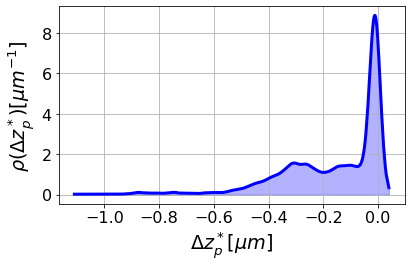

In [11]:
zkernel = stats.gaussian_kde(zdiff, bw_method=0.1)
rho_dz = zkernel(np.sort(zdiff))

fig, ax = plt.subplots()
ax.grid()
ax.set_xlabel(r'$\Delta z_p^* [\mu m]$')
ax.set_ylabel(r'$\rho(\Delta z_p^*) [\mu m^{-1}]$')
ax.plot(np.sort(zdiff), rho_dz, linewidth=3, c='b')
ax.fill_between(np.sort(zdiff), 0, rho_dz, color='b', alpha=0.3)
fig.tight_layout()
fig.savefig('figures/rho_z_error01.png')

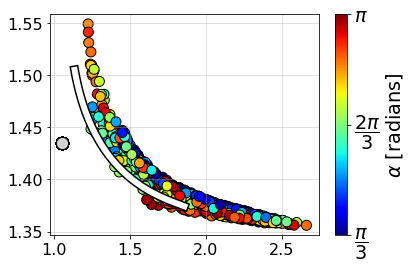

In [12]:
fig, ax = plt.subplots()
ax.scatter(2*a_p, n_p, color='lightgray', ec='k', s=150, label='Monomer')
ct = ax.scatter(td_fit, tn_fit, s=100, c=talpha, cmap = 'jet',  ec='black', vmin=np.pi/3, vmax=np.pi, zorder=1)
ax.plot(d_m, n_m, c='white', linewidth=6, zorder=10, linestyle='-', label='Dimers')
ax.plot(d_m, n_m, c='black', linewidth=9, zorder=9, linestyle='-')
cb= fig.colorbar(ct, ax=ax, ticks =[np.pi/3, np.pi*2/3, np.pi])
cb.set_label(r'$\alpha$ [radians]')
cb.ax.set_yticklabels([r'$\dfrac{\pi}{3}$', r'$\dfrac{2\pi}{3}$', r'$\pi$'])
cb.ax.tick_params(labelsize='large')
ax.grid(alpha=0.5)
fig.tight_layout()

fig.savefig('figures/trimer_alpha_compare02.png')

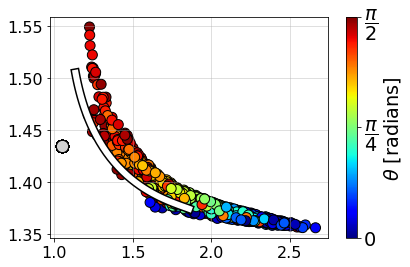

In [13]:
fig, ax = plt.subplots()
ax.scatter(2*a_p, n_p, color='lightgray', ec='k', s=150, label='Monomer')
ct = ax.scatter(td_fit, tn_fit, s=100, c=ttheta, cmap = 'jet',  ec='black', vmin=0, vmax=np.pi/2, zorder=1)
ax.plot(d_m, n_m, c='white', linewidth=6, zorder=10, linestyle='-', label='Dimers')
ax.plot(d_m, n_m, c='black', linewidth=9, zorder=9, linestyle='-')
cb = fig.colorbar(ct, ax=ax, ticks=[0, np.pi/4, np.pi/2])
cb.set_label(r'$\theta$ [radians]')
cb.ax.set_yticklabels(['0', r'$\dfrac{\pi}{4}$', r'$\dfrac{\pi}{2}$'])
cb.ax.tick_params(labelsize='large')

ax.grid(alpha=0.5)
fig.tight_layout()

fig.savefig('figures/trimer_theta_compare01.png')

In [22]:
exp_df = pd.read_json('data/exp_multisphere_fits.json')

d_exp_fit = exp_df.sphere_a_fit *2.
n_exp_fit = exp_df.sphere_n_fit
theta_exp_fit = exp_df.multisphere_theta_fit

In [28]:
def makedistance(point):
    d0, n0 = point
    # drange = sigmoid(0., *popt_d) - sigmoid(np.pi/2., *popt_d)
    # nrange = sigmoid(np.pi/2., *popt_n) - sigmoid(0., *popt_n)
    drange = model(0., dpoly) - model(np.pi/2., dpoly)
    nrange = model(np.pi/2., npoly) - model(0., npoly)
    def distance(theta):
        # delta_d = d0 - sigmoid(theta, *popt_d)
        # delta_n = n0 - sigmoid(theta, *popt_n)
        delta_d = d0 - model(theta, dpoly)
        delta_n = n0 - model(theta, npoly)
        delta = np.sqrt((delta_d/drange)**2 + (delta_n/nrange)**2)
        return delta
    return distance

theta_sphere_fit = []
for i in range(len(d_exp_fit)):
    point = (d_exp_fit[i], n_exp_fit[i])
    distance = makedistance(point)
    res = minimize_scalar(distance, bounds=(0, np.pi/2), method='bounded')
    theta_sphere_fit.append(res.x)

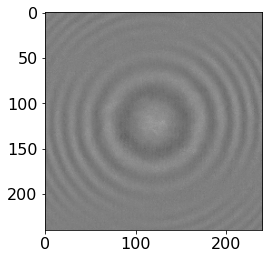

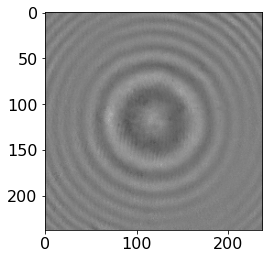

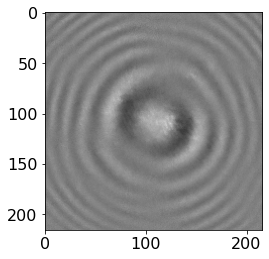

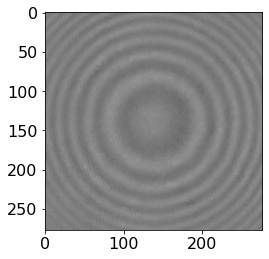

In [39]:
for fname in exp_df.imagename:
        img = cv2.imread('data/exp_crops/' + fname)
        plt.imshow(img)
        plt.show()

In [36]:
exp_df

,a_p,n_p,imagename,sphere_a_fit,sphere_z_fit,sphere_n_fit,spherefit_time,multisphere_theta_fit,multisphere_phi_fit,multisphere_z_fit,multispherefit_time
0,0.527,1.435,crop01_square.png,0.922000,508.918481,1.371205,0.460037,0.302318,0.002619,62.021690,145.502396
1,0.527,1.435,crop02.png,0.536495,501.873891,1.537669,0.289818,1.407694,0.015510,59.943522,204.234834
2,0.527,1.435,crop03.png,1.358389,406.591489,1.362276,0.415745,0.000155,0.308710,57.332901,168.595873
3,0.527,1.435,crop04.png,0.579443,688.185865,1.483592,0.836971,0.000000,0.070651,73.015397,194.980348


Text(0, 0.5, 'Multisphere $\\theta$ fit')

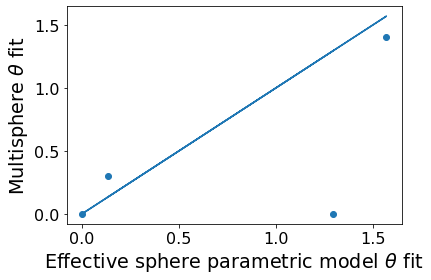

In [42]:
plt.scatter(theta_sphere_fit, theta_exp_fit)
plt.plot(theta_sphere_fit, theta_sphere_fit)
plt.xlabel(r'Effective sphere parametric model $\theta$ fit')
plt.ylabel(r'Multisphere $\theta$ fit')

In [43]:
145/0.46

315.2173913043478